## Problem Statement

Build your own recommendation system for products on an e-commerce website like Amazon.com.
Dataset Link - https://drive.google.com/file/d/1ClBptsK3V5KgKXtK2GSRzFNAW7GnTPDW/view?usp=sharing

 

Dataset columns - first three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.

Source - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/)  The repository has several datasets. For this case study, we are using the Electronics dataset.

## Steps

Please do the analysis based on steps (1 to 8) as given below:

- Read and explore the given dataset. (Rename column/add headers, plot histograms, find data characteristics)
- Take a subset of the dataset to make it less sparse/ denser. (For example, keep the users only who has given 50 or more number of ratings)
- Split the data randomly into train and test dataset. (For example, split it in 70/30 ratio)
- Build Popularity Recommender model.
- Build Collaborative Filtering model.
- Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models.
- Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.
- Summarise your insights.

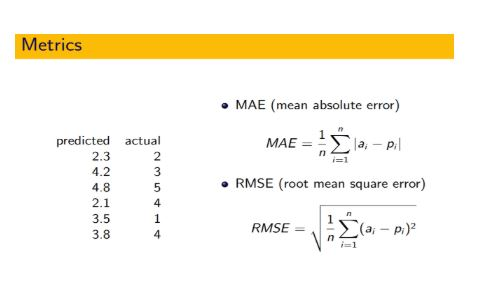

**Please Note**

If you are facing any memory issue while working on this project, create a small subset (Let’s say 10% of data) and work on it.
If you are stuck at the model evaluation part of this project.
Please refer to below links - 

https://surprise.readthedocs.io/en/stable/accuracy.html (Links to an external site.)Links to an external site.
http://surpriselib.com/ (Links to an external site.)Links to an external site. - Getting started, example

## Import required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
from scipy.sparse.linalg import svds

from surprise import SVD, KNNWithMeans
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

import seaborn as sns

## 1. Read and explore the given dataset. (Rename column/add headers, plot histograms, find data characteristics)

In [2]:
#Loading data
ratings = pd.read_csv("Data/ratings_Electronics.csv")

In [3]:
ratings.columns = ['userId', 'productId', 'ratings', 'timestamp']

In [4]:
ratings.head()

,userId,productId,ratings,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [5]:
ratings.drop('timestamp', axis=1, inplace=True)

In [6]:
ratings.head()

,userId,productId,ratings
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [7]:
ratings.count()

userId       7824481
productId    7824481
ratings      7824481
dtype: int64

In [8]:
ratings.drop_duplicates(inplace=True)

### We have taken a subset of the data as it takes large CPU/memory for the entire dataset.

In [9]:
ratings_small = ratings.sample(frac=0.5)

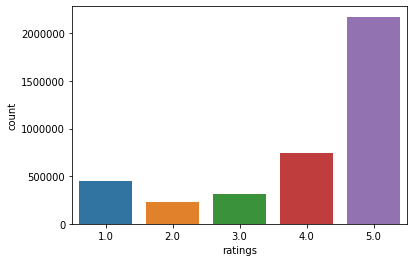

In [10]:
sns.countplot(ratings_small.ratings)

## 2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings)

In [11]:
userGroups = ratings_small.groupby(by='userId').count()

In [12]:
user50 = userGroups.loc[userGroups['productId'] > 49].index

In [13]:
ratings_new = ratings_small.loc[ratings_small.userId.isin (user50)]

In [14]:
ratings_new.shape

(22264, 3)

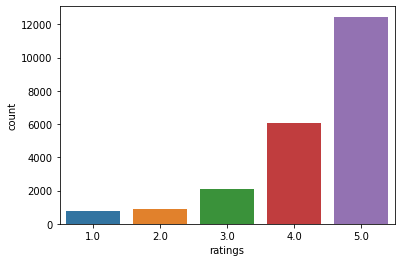

In [15]:
sns.countplot(ratings_new.ratings)

## 3. Split the data randomly into train and test dataset. (For example, split it in 70/30 ratio)

In [16]:
data = Dataset.load_from_df(ratings_new, Reader())

In [17]:
trainset, testset = train_test_split(data, test_size=.30)

## 4. Build Popularity Recommender model.

In [18]:
ratings_new.head()

,userId,productId,ratings
1602109,A20DZX38KRBIT8,B0012GQZZU,1.0
7141376,A1V4VVBQBFXRHC,B00BOHNYTW,5.0
6185788,A2AF0NOCM71J0B,B008DBI6Y0,4.0
407591,AT6CZDCP4TRGA,B0001U6RNI,5.0
4178566,A3IY316DRNF5F2,B004IAPSAA,5.0


### Let's group the books and find out mean ratings for every book

In [19]:
book_ratings = pd.DataFrame(ratings_new.groupby(by='productId', axis=0).mean())

### Let's group the books and find out count of ratings for every book and add to book_ratings

In [20]:
book_ratings['count'] = ratings_new.groupby(by='productId', axis=0).count()['ratings']

### Sorting this table by mean ratings and by number of ratings

In [21]:
book_ratings.sort_values(by='ratings', ascending=False).head()

,ratings,count
productId,,
B003A7CDY6,5.0,1
B003XKWLSS,5.0,3
B003XDU2XG,5.0,1
B003XDU2Y0,5.0,1
B003XESDFO,5.0,1


In [22]:
book_ratings.sort_values(by='count', ascending=False).head()

,ratings,count
productId,,
B0088CJT4U,4.052632,38
B002R5AM7C,4.083333,36
B00829TIEK,4.678571,28
B008DWCRQW,4.111111,27
B004CLYEDC,4.703704,27


### We can suggest Recommendations from above table either based on ratings or based on number of ratings given or a combination of both

## 5. Build Collaborative Filtering model.

### Building and training the model with these best parameters

There are two ways of Collaborative Filtering: Either user-user or item-item.

Here, we will first do the user-user based Collborative filtering and build the model with optimal parameters.

Then, we will do the item-item based Collaborative filtering and build the model with optimal parameters.

### A. User-User Collaborative Filtering:

In [23]:
user_based_param_grid = {'k': [20, 40],
                         'sim_options': {'name': ['pearson_baseline', 'cosine'],
                                         'user_based': [True]}}

In [24]:
gs = GridSearchCV(KNNWithMeans, user_based_param_grid, measures=['rmse'], cv=3)

In [25]:
gs.fit(data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity ma

In [26]:
gs.best_score, gs.best_params

({'rmse': 1.0089574127784655},
 {'rmse': {'k': 20,
   'sim_options': {'name': 'pearson_baseline', 'user_based': True}}})

In [27]:
user_based_model = KNNWithMeans(k=gs.best_params['rmse']['k'],
                                sim_options=gs.best_params['rmse']['sim_options'])

In [28]:
user_based_model.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### B. Item-Item Collaborative Filtering Model

In [29]:
item_based_param_grid = {'k': [20, 40],
                         'sim_options': {'name': ['pearson_baseline', 'cosine'],
                                         'user_based': [False]}}

In [30]:
gs = GridSearchCV(KNNWithMeans, item_based_param_grid, measures=['rmse'], cv=3)

In [31]:
gs.fit(data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity ma

In [32]:
gs.best_score, gs.best_params

({'rmse': 1.0725635184138864},
 {'rmse': {'k': 20,
   'sim_options': {'name': 'pearson_baseline', 'user_based': False}}})

In [33]:
item_based_model = KNNWithMeans(k=gs.best_params['rmse']['k'],
                                sim_options=gs.best_params['rmse']['sim_options'])

In [34]:
item_based_model.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


## 6. Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models.

In [35]:
user_pred = user_based_model.test(testset)

In [36]:
print('Accuracy of the user-user Collaborative Filtering Model:')
accuracy.rmse(user_pred), accuracy.mae(user_pred)

Accuracy of the user-user Collaborative Filtering Model:
RMSE: 1.0145
MAE:  0.7729


(1.014501217774407, 0.7728959137330035)

In [37]:
item_pred = item_based_model.test(testset)

In [38]:
print('Accuracy of the item-item Collaborative Filtering Model:')
accuracy.rmse(item_pred), accuracy.mae(item_pred)

Accuracy of the item-item Collaborative Filtering Model:
RMSE: 1.0785
MAE:  0.7841


(1.078531981694536, 0.7840748185382526)

### Evaluation Summary:

- Poulation model cannot be quantitatively assessed unlike the Collaborative filtering model.
- Accuracy of the Collaborative filtering model can be assessed by RMSE (or MAE) value.
- RMSE (or MAE) value should be less for any model.
- Here, RMSE (or MAE) value is lower for user-user model than item-item model.
- Moreover, we observed that item-item based model takes more CPU/memory than user-user based. May be due to large number of items than users.
- So, user-user model is more accurate and efficient than the item-item model.
- RMSE of both collaborative filtering model is almost 1; seems, the model needs further tuning 

## 7. Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

#### Function for getting top5 prediections from the model.test() prediction

In [39]:
def get_top_5(predictions):

    reco = []
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        
        top_5_per_user = []
        top_5_per_user.append(uid)
        for ii in range(5):
            top_5_per_user.append(user_ratings[ii][0])
            #print(user_ratings[ii][1])
        reco.append(top_5_per_user)

    reco_df = pd.DataFrame(reco, columns=['userId', 'Reco1', 'Reco2', 'Reco3', 'Reco4', 'Reco5'])
    return reco_df

Building anti_testset for user-item combinations which are not yet rated. 

In [40]:
anti_test = trainset.build_anti_testset()

### A. Predictions from user-user based Model:

In [41]:
pred_anti_test = user_based_model.test(anti_test)

In [42]:
top5_user_based_df = get_top_5(pred_anti_test)

In [43]:
top5_user_based_df.head()

,userId,Reco1,Reco2,Reco3,Reco4,Reco5
0,A3LGT6UZL99IW1,B0080EBMM8,B000BI2162,B005QX7KYU,B004N625BY,B0002CPBWI
1,A2ARDVMUGDFED6,B004NY9UV4,B008X9ZBVI,B006JD3F0Y,B0009SV24G,B000N99BBC
2,A250AXLRBVYKB4,B00CI3BIWQ,B006LW0W5Y,B002IO2UM2,B003GDFJUO,B000095SB4
3,A2BLFCOPSMBOZ9,B00JWXBM62,B001E1Y5O6,B003UH0Z9Q,B00FP3OX3C,B002MAPSQM
4,A2R6RA8FRBS608,B00007E7QS,B002BH4MEA,B00BQ4F9ZA,B000TFIWQK,B000VE4PNS


### B. Predictions from item-item based Model:

In [44]:
pred_anti_test = item_based_model.test(anti_test)

In [45]:
top5_item_based_df = get_top_5(pred_anti_test)

In [46]:
top5_item_based_df.head()

,userId,Reco1,Reco2,Reco3,Reco4,Reco5
0,A3LGT6UZL99IW1,B002BH4MEA,B000TFIWQK,B000VE4PNS,B0001FV3C8,B001RNNXQM
1,A2ARDVMUGDFED6,B000TFIWQK,B000VE4PNS,B0001FV3C8,B001RNNXQM,B000GA7048
2,A250AXLRBVYKB4,B002BH4MEA,B000TFIWQK,B000VE4PNS,B0001FV3C8,B001RNNXQM
3,A2BLFCOPSMBOZ9,B002BH4MEA,B000VE4PNS,B0001FV3C8,B001RNNXQM,B000GA7048
4,A2R6RA8FRBS608,B002BH4MEA,B000TFIWQK,B000VE4PNS,B0001FV3C8,B001RNNXQM


### C. Predictions from user-item based model

For the user-item model, we will use matrix factorization technique e.g. SVD.
- We will create a user-product matrix
- Apply SVD to find probability of every user-product combination
- Remove products already rated by the user
- List the remaining products in decreasing probablity order
- Get the top 5 recommendations

In [47]:
user_product = pd.pivot(ratings_new, index='userId', columns='productId', values='ratings').fillna(0)

In [48]:
user_product.head()

productId,0970407998,1400501466,1400599997,7562434166,787988002X,9043413585,9800359788,9981719005,B000001OMN,B000001ON0,...,B00L0YFJHY,B00L1I727Y,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L3YHF6O,B00L403O94,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10PEXB6XAQ5XF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10Y058K7B96C6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10ZFE6YE0UHW8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
U, sigma, VT = svds(user_product, k=50)

In [50]:
sigma = np.diag(sigma)

In [51]:
users_item_prob = np.dot(np.dot(U, sigma), VT)

In [52]:
user_item_prob_df = pd.DataFrame(users_item_prob, columns=user_product.columns, index=user_product.index)

In [53]:
user_item_prob_df.head()

productId,0970407998,1400501466,1400599997,7562434166,787988002X,9043413585,9800359788,9981719005,B000001OMN,B000001ON0,...,B00L0YFJHY,B00L1I727Y,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L3YHF6O,B00L403O94,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.000489,0.000430,-0.000264,0.001023,0.001553,-0.004923,0.057848,0.052781,-0.000181,0.111762,...,-0.015198,0.026217,-0.023921,0.080002,0.054941,0.114335,-0.015208,0.013913,0.110153,-0.002677
A100WO06OQR8BQ,-0.004651,0.000426,-0.000145,-0.001642,0.042545,-0.024539,0.020221,-0.014188,0.000030,0.096839,...,-0.016634,-0.017257,0.155870,-0.051489,0.004622,-0.154945,-0.004308,-0.231662,-0.073737,-0.012222
A10PEXB6XAQ5XF,-0.001531,0.000146,0.000050,-0.000824,0.014591,0.006480,-0.042209,0.049096,-0.000163,-0.021289,...,0.031729,-0.032557,0.159527,-0.073013,0.096618,0.009082,0.019849,0.008179,0.066227,0.007661
A10Y058K7B96C6,-0.001058,-0.000639,0.000646,0.007134,0.018343,0.094758,-0.030164,-0.000643,0.000947,-0.088918,...,-0.063953,-0.055860,0.157971,-0.119873,-0.110414,0.238329,0.015878,0.139932,0.107829,-0.016613
A10ZFE6YE0UHW8,-0.000940,-0.000251,-0.000068,0.000375,0.012610,0.002404,-0.016917,0.034766,-0.000199,0.100928,...,0.010524,-0.076285,0.459715,-0.114894,0.246568,-0.107591,-0.000528,-0.171905,-0.036989,0.007995


In [54]:
probabilities = []

In [55]:
for user in user_item_prob_df.index:
    #user = 'A100WO06OQR8BQ'
    top5_per_user = []
    top5_per_user.append(user)

    user_products = ratings_new.loc[ratings_new.userId == user]
    #print(user_products.head(10))
    user_predictions = user_item_prob_df.loc[user].sort_values(ascending=False)
    #print(user_predictions.head(10))

    reco = user_predictions.loc[~user_predictions.index.isin(user_products.productId)]
    for ii in range(5):
        top5_per_user.append(reco.index[ii])

    probabilities.append(top5_per_user)

In [56]:
user_item_pred_df = pd.DataFrame(probabilities, columns=['userId', 'Reco1', 'Reco2', 'Reco3', 'Reco4', 'Reco5'])

In [57]:
user_item_pred_df.head()

,userId,Reco1,Reco2,Reco3,Reco4,Reco5
0,A100UD67AHFODS,B003ES5ZUU,B00F0DD0I6,B002WE4HE2,B00DK2JQOQ,B002V88HFE
1,A100WO06OQR8BQ,B004CLYEDC,B0088CJT4U,B0097CZHAU,B000N99BBC,B0097CXWUW
2,A10PEXB6XAQ5XF,B0088CJT4U,B004CLYEDC,B004CLYEFK,B002R5AM7C,B000N99BBC
3,A10Y058K7B96C6,B002R5AM7C,B009NHWVIA,B00BOHNYU6,B00829TIEK,B00834SJSK
4,A10ZFE6YE0UHW8,B002R5AM7C,B00KVNY2KA,B00834SJSK,B00D50UNRM,B00G500AE0


## 8. Summarise your insights.

- *Popularity based model* gives recommendations only on the popularity ratings, either based on count of ratings or based on highest ratings.
- *Collaborative* filtering can be dones by user-user and item-item based similarities. The model is created by training a given set of data. The same model is used to predict the ratings for products, which are not yet rated by the user.
    - From the prediction of item-item model, we see that for many users, the item predictions are similar to each other. This is obvious as similarities of items are measured and items are arranged based on their neighbours. 
- *SVD Algorithm* is used to compute the probablity of ratings of all products, including the ones not yet rated by the user.
- All models, user-user, item-item and user-item give different predictions for single user. This  is good as one single user should be given different recommendations based on different algorithms/choices.